In [20]:
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Version with step-by-step loss

In [4]:
# Dict to convert movement idx to actual movement coordinates
idx2mov = {0:np.array([1,0], dtype=int), 
           1:np.array([-1,0], dtype=int), 
           2:np.array([0,1], dtype=int), 
           3:np.array([0,-1], dtype=int)}

# Convert coordinate to flattened idx
def loc2idx(loc, grid_size=np.array([5, 5], dtype=int)):
    return loc[0]*grid_size[0] + loc[1]

# Convert location flattened idx to coordinate
def idx2loc(idx, grid_size=np.array([5, 5], dtype=int)):
    return np.array([idx // grid_size[0], idx % grid_size[0]], dtype=int)


def sample_n_back_spatial(n, max_length=40, grid_size=np.array([5, 5], dtype=int), boundary='periodic', return_trajectory=False):
    """
    Function to generate a sample for the n-back spatial task.

    Args:
    - n: response delay
    - p_stop: after n steps, probability of stoping walk (default=0.05)
    - max_length: maximum trajectory length (left zero-padding is applied to reach this length)
    - grid_size (array-like): size of gridworld, must be odd (default=[5,5])
    - boundary ['periodic', 'strict']: boundary conditions
    - return_trajectory (bool): whether to return trajectory

    Returns: movements (1D array, as index), n_back_idx (n-back location as idx), (trajectory) 
    
    """
    assert boundary in ['periodic', 'strict'], "boundary must be either 'periodic' or 'strict'"
    assert (grid_size[0] % 2 == 1) & (grid_size[1] % 2 == 1), "grid size must be odd"

    zero = np.array([(grid_size[0]-1)//2, (grid_size[1]-1)//2], dtype=int)
    movements = np.random.randint(4, size=max_length)
    
    trajectory = [zero]
    
    for idx in movements:
        if boundary == 'periodic':
            trajectory.append((trajectory[-1] + idx2mov[idx]) % grid_size)
        elif boundary == 'strict':
            trajectory.append(np.clip(trajectory[-1] + idx2mov[idx], a_min=[0,0], a_max=grid_size-1))
        
    trajectory = np.array(trajectory)

    n_back_idx = np.array([loc2idx(trajectory[i], grid_size=grid_size) for i in range(max_length-n+1)])

    if return_trajectory:
        return movements, n_back_idx, trajectory
    else:
        return movements, n_back_idx


In [5]:
x, y = sample_n_back_spatial(3, boundary='strict')
y.shape

(38,)

In [6]:
from torch.utils.data import Dataset, DataLoader
import torch

class NBackDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)
		
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

def create_n_back_dataset(num_samples, n, max_length=40, grid_size=np.array([5, 5], dtype=int), boundary='periodic'):
    X, Y = [], []
    for _ in range(num_samples):
        x, y = sample_n_back_spatial(n, max_length=max_length, grid_size=grid_size, boundary=boundary)
        X.append(x); Y.append(y)

    X = np.vstack(X)
    Y = np.vstack(Y)

    X = torch.tensor(X, dtype=int)
    Y = torch.tensor(Y, dtype=int)

    return NBackDataset(X, Y)

In [7]:
data = create_n_back_dataset(100, 3)
data[0][1].size()

torch.Size([38])

In [8]:
import torch.nn.functional as F
from torch import nn

class GRUExplorer(nn.Module):
    
    def __init__(self, hidden_state_size, num_layers=1, grid_size=np.array([5, 5], dtype=int), dropout=0.2):

        super(GRUExplorer, self).__init__()

        self.hidden_state_size = hidden_state_size
        self.output_size = grid_size[0]*grid_size[1]
        self.num_layers = num_layers

        self.core = nn.GRU(4, self.hidden_state_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.head = nn.Linear(self.hidden_state_size, self.output_size)

    def forward(self, X, return_hidden=False):

        X = F.one_hot(X, num_classes=4).to(torch.float32)
        h0 = torch.zeros(self.num_layers, X.size(0), self.hidden_state_size).to(X.device)

        states, _= self.core(X, h0)
        states = torch.cat((h0[-1:].transpose(0,1), states), 1)
        
        logits = self.head(self.dropout(states))
        
        if return_hidden:
            return logits.transpose(1,2), states
        else:
            return logits.transpose(1,2)

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    loss_list = []
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_list.append(loss.item())

    return np.mean(loss_list)
#            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1)[:, loss_fn.n_back:] == y).type(torch.float).mean().item()
    test_loss /= num_batches
    correct /= num_batches
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

In [10]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [72]:
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR

batch_size = 1000
epochs = 200
train_sample_size = 100_000
test_sample_size = 10_000

n_back = 10
hidden_units = 128
num_layers = 1
lr = 0.001

class NBackLoss(nn.Module):
    
    def __init__(self, n_back):
        super(NBackLoss, self).__init__()
        
        self.n_back = n_back
        self.loss = nn.CrossEntropyLoss()

    def __call__(self, logits, target):
        
        return self.loss(logits[:, :, self.n_back:], target)


def sample_and_train(n_back, hidden_units, num_layers=1, train_sample_size=100_000, test_sample_size=10_000, batch_size=1000, epochs=10, lr=0.001, dropout=0.2, l2_reg=0., boundary='strict'):

    train_dataloader = DataLoader(create_n_back_dataset(train_sample_size, n_back, boundary=boundary), batch_size=batch_size)
    test_dataloader = DataLoader(create_n_back_dataset(test_sample_size, n_back, boundary=boundary), batch_size=batch_size)
        
    
    model = GRUExplorer(hidden_units, num_layers=num_layers).to(device)
    loss_fn = NBackLoss(n_back)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg)
    # scheduler = ExponentialLR(optimizer, gamma=0.9)
    
    acc, test_loss, train_loss = [], [], []
    
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        tr = train(train_dataloader, model, loss_fn, optimizer)
        a, t = test(test_dataloader, model, loss_fn)
        acc.append(a); test_loss.append(t); train_loss.append(tr)
    #    scheduler.step()
    print("Done!")

    return model, acc, test_loss, train_loss

In [212]:
np.random.seed(0)

_, acc, test_loss, train_loss = sample_and_train(0, 64, num_layers=1, dropout=0.2, l2_reg=0.00, lr=0.00125, batch_size=128, epochs=50)

/home/ikarmann/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1
-------------------------------
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.253402 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.056736 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.027715 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.010100 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005230 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.002969 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001967 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001290 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000876 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000598 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 100.0%

KeyboardInterrupt: 

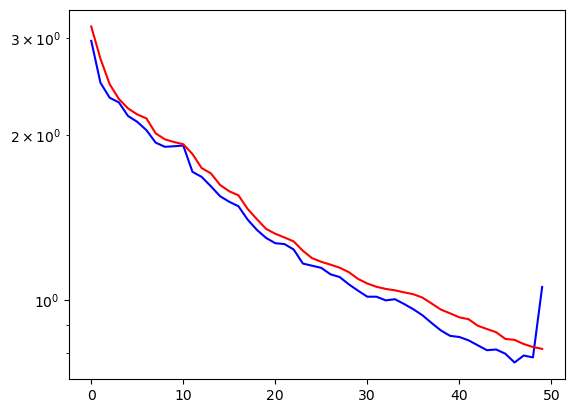

In [128]:
import matplotlib.pyplot as plt

plt.plot(test_loss, color='b')
plt.plot(train_loss, color='r')
plt.yscale('log')

In [92]:
import itertools as itt
from tqdm import tqdm

list_hidden_units = [64, 128, 258]#, 512]
list_n_back = np.arange(21)

grid_dict = { 
    'acc' : [],
    'test_loss' : [],
    'train_loss': [],
    'hidden_units' : [],
    'n_back' : [],
}

for hidden_units, n_back in tqdm(itt.product(list_hidden_units, list_n_back)):

    print(f"Computing with {hidden_units} hidden units, {n_back}-back task")
    _, acc, test_loss, train_loss = sample_and_train(n_back, hidden_units, num_layers=1, lr=0.00125, batch_size=128, epochs=50)

    grid_dict['acc'].append(np.array(acc))
    grid_dict['test_loss'].append(np.array(test_loss))
    grid_dict['train_loss'].append(np.array(train_loss))
    grid_dict['hidden_units'].append(hidden_units)
    grid_dict['n_back'].append(n_back)

0it [00:00, ?it/s]

Computing with 64 hidden units, 0-back task


/home/ikarmann/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1
-------------------------------
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.101904 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.013885 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.004049 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001643 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000720 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000745 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000389 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000258 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000168 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000107 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 100.0

1it [02:08, 128.34s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000000 

Done!
Computing with 64 hidden units, 1-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 92.6%, Avg loss: 0.367350 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.044992 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.013273 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.004761 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.002297 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001252 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000679 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000375 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000641 

Epoch 10
-------------------------------
Test Error: 
 Accurac

2it [04:18, 129.37s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000003 

Done!
Computing with 64 hidden units, 2-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 70.0%, Avg loss: 0.818849 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 92.0%, Avg loss: 0.318958 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 98.9%, Avg loss: 0.083308 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.020760 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 97.4%, Avg loss: 0.090519 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 99.1%, Avg loss: 0.033054 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.003052 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001571 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 93.8%, Avg loss: 0.354351 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 1

3it [06:26, 128.92s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000003 

Done!
Computing with 64 hidden units, 3-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 60.4%, Avg loss: 1.052711 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 78.0%, Avg loss: 0.623232 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 91.1%, Avg loss: 0.315001 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 98.9%, Avg loss: 0.087002 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.034995 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.013950 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.006829 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.004331 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.002508 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 

4it [08:29, 126.52s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000002 

Done!
Computing with 64 hidden units, 4-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 56.8%, Avg loss: 1.148808 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 74.0%, Avg loss: 0.725474 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 87.6%, Avg loss: 0.396025 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 95.8%, Avg loss: 0.173109 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 99.1%, Avg loss: 0.065114 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.022733 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.010995 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.007201 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.004321 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 1

5it [10:33, 125.55s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000003 

Done!
Computing with 64 hidden units, 5-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 52.3%, Avg loss: 1.255648 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 65.8%, Avg loss: 0.899661 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 79.2%, Avg loss: 0.597327 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 90.9%, Avg loss: 0.317535 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 96.2%, Avg loss: 0.165316 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 98.9%, Avg loss: 0.072049 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.028773 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 96.2%, Avg loss: 0.136807 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.007988 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 100

6it [12:38, 125.20s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000007 

Done!
Computing with 64 hidden units, 6-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 47.8%, Avg loss: 1.394735 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 60.1%, Avg loss: 1.053906 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 71.7%, Avg loss: 0.756885 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 79.7%, Avg loss: 0.569330 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 86.5%, Avg loss: 0.411390 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 90.8%, Avg loss: 0.296679 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 94.5%, Avg loss: 0.199708 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 97.2%, Avg loss: 0.114899 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.090740 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 99.2

7it [14:41, 124.72s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000034 

Done!
Computing with 64 hidden units, 7-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 19.4%, Avg loss: 2.124444 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 22.7%, Avg loss: 1.836693 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 24.2%, Avg loss: 1.702022 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 25.2%, Avg loss: 1.591114 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 29.5%, Avg loss: 1.532060 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 62.3%, Avg loss: 0.947158 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 78.6%, Avg loss: 0.594181 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 87.1%, Avg loss: 0.383085 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 92.5%, Avg loss: 0.249092 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 94.9

8it [16:48, 125.33s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000174 

Done!
Computing with 64 hidden units, 8-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 21.2%, Avg loss: 2.311164 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 47.7%, Avg loss: 1.400440 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 62.2%, Avg loss: 1.015772 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 71.9%, Avg loss: 0.765272 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.590293 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 84.2%, Avg loss: 0.450626 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 87.4%, Avg loss: 0.367175 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 91.6%, Avg loss: 0.261325 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 93.0%, Avg loss: 0.220747 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 95.6

9it [18:55, 125.79s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000679 

Done!
Computing with 64 hidden units, 9-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 19.6%, Avg loss: 2.092088 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 21.5%, Avg loss: 1.897553 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 23.3%, Avg loss: 1.737983 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 24.6%, Avg loss: 1.649454 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 25.6%, Avg loss: 1.592804 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 26.5%, Avg loss: 1.540782 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 29.8%, Avg loss: 1.510801 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 35.6%, Avg loss: 1.446051 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 44.3%, Avg loss: 1.324029 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 46.8

10it [20:59, 125.38s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000719 

Done!
Computing with 64 hidden units, 10-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 19.3%, Avg loss: 2.192261 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 23.7%, Avg loss: 1.953750 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 25.4%, Avg loss: 1.834625 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 26.5%, Avg loss: 1.747385 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 27.6%, Avg loss: 1.682754 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 28.5%, Avg loss: 1.614454 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 29.3%, Avg loss: 1.558031 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 29.8%, Avg loss: 1.518377 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 30.5%, Avg loss: 1.480447 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 31.

11it [23:04, 125.20s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001456 

Done!
Computing with 64 hidden units, 11-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 18.5%, Avg loss: 2.473649 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 23.6%, Avg loss: 2.018157 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 25.2%, Avg loss: 1.898168 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 25.3%, Avg loss: 1.885292 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 26.7%, Avg loss: 1.796328 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 27.9%, Avg loss: 1.703723 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 28.8%, Avg loss: 1.651559 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 29.6%, Avg loss: 1.597051 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 30.4%, Avg loss: 1.554340 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 29.

12it [25:08, 124.78s/it]

Test Error: 
 Accuracy: 99.8%, Avg loss: 0.011577 

Done!
Computing with 64 hidden units, 12-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 16.8%, Avg loss: 2.544805 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 19.9%, Avg loss: 2.244941 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 20.6%, Avg loss: 1.977018 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 21.6%, Avg loss: 1.877879 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 23.3%, Avg loss: 1.782491 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 24.3%, Avg loss: 1.707336 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 25.0%, Avg loss: 1.658928 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 27.7%, Avg loss: 1.596973 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 29.6%, Avg loss: 1.539555 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 30.8

13it [27:09, 123.65s/it]

Test Error: 
 Accuracy: 99.9%, Avg loss: 0.004928 

Done!
Computing with 64 hidden units, 13-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 10.3%, Avg loss: 2.981976 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 19.0%, Avg loss: 2.603403 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 26.4%, Avg loss: 2.198920 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 34.1%, Avg loss: 1.887004 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 37.6%, Avg loss: 1.741731 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 42.4%, Avg loss: 1.574261 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 45.8%, Avg loss: 1.458132 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 48.0%, Avg loss: 1.380021 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 51.0%, Avg loss: 1.288990 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 54.0

14it [29:12, 123.44s/it]

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.067859 

Done!
Computing with 64 hidden units, 14-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 10.9%, Avg loss: 2.957785 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 17.4%, Avg loss: 2.590452 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 20.2%, Avg loss: 2.302985 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 21.5%, Avg loss: 2.183690 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 22.9%, Avg loss: 2.089264 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 24.2%, Avg loss: 2.006781 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 24.8%, Avg loss: 1.965824 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 25.6%, Avg loss: 1.917199 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 26.0%, Avg loss: 1.885004 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 26.5

15it [31:16, 123.55s/it]

Test Error: 
 Accuracy: 90.3%, Avg loss: 0.278564 

Done!
Computing with 64 hidden units, 15-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 11.5%, Avg loss: 2.913823 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 11.3%, Avg loss: 2.913404 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 17.0%, Avg loss: 2.645499 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 19.2%, Avg loss: 2.456722 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 20.1%, Avg loss: 2.345534 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 21.0%, Avg loss: 2.254284 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 21.6%, Avg loss: 2.185477 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 23.0%, Avg loss: 2.098606 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 23.8%, Avg loss: 2.035219 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 24.4

16it [33:16, 122.74s/it]

Test Error: 
 Accuracy: 36.5%, Avg loss: 1.397038 

Done!
Computing with 64 hidden units, 16-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 11.6%, Avg loss: 2.902463 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 12.9%, Avg loss: 2.864742 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 18.3%, Avg loss: 2.566604 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 20.4%, Avg loss: 2.431862 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 21.1%, Avg loss: 2.351211 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 21.9%, Avg loss: 2.259549 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 22.6%, Avg loss: 2.183492 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 22.7%, Avg loss: 2.150353 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 23.7%, Avg loss: 2.094710 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 24.3

17it [35:17, 121.98s/it]

Test Error: 
 Accuracy: 32.7%, Avg loss: 1.521380 

Done!
Computing with 64 hidden units, 17-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 15.4%, Avg loss: 2.709923 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 21.4%, Avg loss: 2.286355 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 24.5%, Avg loss: 2.106268 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 36.3%, Avg loss: 1.799053 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 38.2%, Avg loss: 1.716638 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 39.3%, Avg loss: 1.670148 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 45.0%, Avg loss: 1.491166 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 47.2%, Avg loss: 1.422505 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 49.9%, Avg loss: 1.335577 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 51.7

18it [37:18, 121.78s/it]

Test Error: 
 Accuracy: 88.8%, Avg loss: 0.315917 

Done!
Computing with 64 hidden units, 18-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 9.4%, Avg loss: 2.990731 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 9.4%, Avg loss: 3.059055 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 12.5%, Avg loss: 2.970854 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 13.0%, Avg loss: 2.857188 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 13.8%, Avg loss: 2.841561 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 18.4%, Avg loss: 2.571351 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 24.4%, Avg loss: 2.310142 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 32.3%, Avg loss: 1.985322 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 32.7%, Avg loss: 1.935392 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 34.9%,

19it [39:19, 121.66s/it]

Test Error: 
 Accuracy: 80.7%, Avg loss: 0.518563 

Done!
Computing with 64 hidden units, 19-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 9.2%, Avg loss: 3.016184 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 12.6%, Avg loss: 2.865612 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 12.7%, Avg loss: 2.852625 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 9.8%, Avg loss: 3.146213 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 9.8%, Avg loss: 3.061505 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 9.8%, Avg loss: 2.992752 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 13.3%, Avg loss: 2.848244 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 14.8%, Avg loss: 2.802342 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 16.9%, Avg loss: 2.707444 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 18.2%, A

20it [41:23, 122.30s/it]

Test Error: 
 Accuracy: 61.8%, Avg loss: 0.985922 

Done!
Computing with 64 hidden units, 20-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 9.7%, Avg loss: 2.955333 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 9.6%, Avg loss: 2.986037 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 13.3%, Avg loss: 2.935295 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 13.0%, Avg loss: 2.837171 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 12.9%, Avg loss: 2.802750 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 14.0%, Avg loss: 2.758510 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 21.1%, Avg loss: 2.396921 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 24.4%, Avg loss: 2.199355 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 36.4%, Avg loss: 1.788356 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 40.7%,

21it [43:24, 121.80s/it]

Test Error: 
 Accuracy: 83.5%, Avg loss: 0.443594 

Done!
Computing with 128 hidden units, 0-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.067498 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.009115 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.002986 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001771 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001621 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000729 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000400 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000231 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000129 

Epoch 10
-------------------------------
Test Error: 
 Accura

22it [45:36, 124.95s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000001 

Done!
Computing with 128 hidden units, 1-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 97.9%, Avg loss: 0.161434 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.014121 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.003954 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.006795 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.002297 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001056 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000529 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000278 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000148 

Epoch 10
-------------------------------
Test Error: 
 Accur

23it [47:48, 126.99s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000000 

Done!
Computing with 128 hidden units, 2-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 84.0%, Avg loss: 0.511942 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.080061 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.009009 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.004423 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001741 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.002990 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000975 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000480 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001758 

Epoch 10
-------------------------------
Test Error: 
 Accura

24it [49:59, 128.40s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000000 

Done!
Computing with 128 hidden units, 3-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 74.6%, Avg loss: 0.707936 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 99.4%, Avg loss: 0.072764 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 97.2%, Avg loss: 0.105654 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.004308 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001797 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.003404 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001338 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000666 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000354 

Epoch 10
-------------------------------
Test Error: 
 Accurac

25it [52:11, 129.40s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000000 

Done!
Computing with 128 hidden units, 4-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 65.4%, Avg loss: 0.916179 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 92.3%, Avg loss: 0.276918 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.052466 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005970 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008307 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001879 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000872 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000446 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000238 

Epoch 10
-------------------------------
Test Error: 
 Accurac

26it [54:27, 131.30s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000002 

Done!
Computing with 128 hidden units, 5-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 55.3%, Avg loss: 1.187434 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 81.1%, Avg loss: 0.531457 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.091125 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.013677 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005027 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.002096 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001006 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000493 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.003947 

Epoch 10
-------------------------------
Test Error: 
 Accuracy

27it [56:41, 132.10s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000001 

Done!
Computing with 128 hidden units, 6-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 58.9%, Avg loss: 1.076694 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 77.7%, Avg loss: 0.611141 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 94.0%, Avg loss: 0.213190 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.029221 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008007 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.004340 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001895 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000925 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000480 

Epoch 10
-------------------------------
Test Error: 
 Accuracy

28it [58:56, 133.09s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000004 

Done!
Computing with 128 hidden units, 7-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 57.4%, Avg loss: 1.123688 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 78.6%, Avg loss: 0.598345 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 87.3%, Avg loss: 0.377214 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.072305 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.019202 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.010727 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.003220 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001599 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000847 

Epoch 10
-------------------------------
Test Error: 
 Accuracy:

29it [1:01:12, 133.88s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000001 

Done!
Computing with 128 hidden units, 8-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 54.1%, Avg loss: 1.204003 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.862455 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.460868 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 93.3%, Avg loss: 0.217198 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 99.0%, Avg loss: 0.051690 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.018214 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.010612 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.003771 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.002953 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 1

30it [1:03:25, 133.51s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000005 

Done!
Computing with 128 hidden units, 9-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 41.9%, Avg loss: 1.587720 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 64.7%, Avg loss: 0.949693 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 76.4%, Avg loss: 0.632064 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 85.8%, Avg loss: 0.390883 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 92.2%, Avg loss: 0.230528 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 95.7%, Avg loss: 0.147251 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.065398 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.073888 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.019727 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 99.

31it [1:05:37, 133.30s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000106 

Done!
Computing with 128 hidden units, 10-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 48.2%, Avg loss: 1.405795 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 63.2%, Avg loss: 0.968814 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 72.9%, Avg loss: 0.721079 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 82.2%, Avg loss: 0.490665 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 88.9%, Avg loss: 0.327962 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 96.3%, Avg loss: 0.129447 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.102969 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.062131 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 99.5%, Avg loss: 0.024646 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 99

32it [1:07:50, 133.01s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000027 

Done!
Computing with 128 hidden units, 11-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 10.3%, Avg loss: 2.949031 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 20.2%, Avg loss: 2.411366 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 24.5%, Avg loss: 1.990689 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 27.8%, Avg loss: 1.820469 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 49.2%, Avg loss: 1.310650 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 66.1%, Avg loss: 0.861042 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 75.4%, Avg loss: 0.632530 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 83.4%, Avg loss: 0.435417 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 91.1%, Avg loss: 0.254384 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 95

33it [1:10:01, 132.50s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000429 

Done!
Computing with 128 hidden units, 12-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 21.3%, Avg loss: 2.284234 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 46.0%, Avg loss: 1.438920 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 60.2%, Avg loss: 1.033596 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 72.4%, Avg loss: 0.725538 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 60.9%, Avg loss: 1.003346 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 78.0%, Avg loss: 0.579181 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 85.7%, Avg loss: 0.396481 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 91.6%, Avg loss: 0.252356 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 96.6%, Avg loss: 0.121773 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 98

34it [1:12:14, 132.72s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000077 

Done!
Computing with 128 hidden units, 13-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 32.4%, Avg loss: 1.887211 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 53.1%, Avg loss: 1.219188 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 62.3%, Avg loss: 0.988537 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 75.6%, Avg loss: 0.654583 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 78.8%, Avg loss: 0.576822 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 78.7%, Avg loss: 0.559280 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 93.2%, Avg loss: 0.201375 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 96.4%, Avg loss: 0.113040 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 81.9%, Avg loss: 0.506495 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 97

35it [1:14:29, 133.20s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000137 

Done!
Computing with 128 hidden units, 14-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 10.5%, Avg loss: 2.960427 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 22.4%, Avg loss: 2.155248 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 27.5%, Avg loss: 1.817917 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 32.0%, Avg loss: 1.671106 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 56.4%, Avg loss: 1.114049 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 71.1%, Avg loss: 0.732929 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 78.5%, Avg loss: 0.545384 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 83.7%, Avg loss: 0.427889 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 89.0%, Avg loss: 0.298684 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 93

36it [1:16:39, 132.44s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000140 

Done!
Computing with 128 hidden units, 15-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 11.1%, Avg loss: 2.904651 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 18.6%, Avg loss: 2.241286 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 20.6%, Avg loss: 2.024002 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 38.2%, Avg loss: 1.609850 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 56.6%, Avg loss: 1.131614 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 67.3%, Avg loss: 0.845486 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 66.6%, Avg loss: 0.899391 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 71.2%, Avg loss: 0.769548 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 81.4%, Avg loss: 0.509724 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 82

37it [1:18:49, 131.55s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001246 

Done!
Computing with 128 hidden units, 16-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 18.7%, Avg loss: 2.381796 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 23.8%, Avg loss: 2.073009 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 26.4%, Avg loss: 1.911160 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 27.7%, Avg loss: 1.820840 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 30.9%, Avg loss: 1.649345 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 33.3%, Avg loss: 1.535680 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 35.1%, Avg loss: 1.473596 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 54.2%, Avg loss: 1.142291 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 65.8%, Avg loss: 0.848868 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 74

38it [1:20:55, 129.91s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000437 

Done!
Computing with 128 hidden units, 17-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 11.9%, Avg loss: 2.887163 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 23.5%, Avg loss: 2.141368 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 26.1%, Avg loss: 1.959237 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 27.7%, Avg loss: 1.859774 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 29.0%, Avg loss: 1.774571 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 30.9%, Avg loss: 1.676523 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 32.5%, Avg loss: 1.599849 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 34.1%, Avg loss: 1.539867 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 34.0%, Avg loss: 1.544068 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 35

39it [1:23:14, 132.64s/it]

Test Error: 
 Accuracy: 99.8%, Avg loss: 0.008035 

Done!
Computing with 128 hidden units, 18-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 9.6%, Avg loss: 3.038999 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 12.3%, Avg loss: 2.893196 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 20.2%, Avg loss: 2.348160 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 22.7%, Avg loss: 2.141087 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 26.8%, Avg loss: 1.915661 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 27.8%, Avg loss: 1.848535 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 28.6%, Avg loss: 1.794182 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 29.7%, Avg loss: 1.750042 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 31.5%, Avg loss: 1.711759 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 45.7

40it [1:25:24, 131.74s/it]

Test Error: 
 Accuracy: 95.1%, Avg loss: 0.152519 

Done!
Computing with 128 hidden units, 19-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 17.8%, Avg loss: 2.386741 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 26.3%, Avg loss: 2.042983 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 44.1%, Avg loss: 1.539323 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 51.8%, Avg loss: 1.284398 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 56.1%, Avg loss: 1.138258 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 63.8%, Avg loss: 0.937460 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 68.4%, Avg loss: 0.820137 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 71.8%, Avg loss: 0.731879 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 72.3%, Avg loss: 0.713516 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 75.

41it [1:27:34, 131.32s/it]

Test Error: 
 Accuracy: 95.3%, Avg loss: 0.146397 

Done!
Computing with 128 hidden units, 20-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 16.1%, Avg loss: 2.507320 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 26.1%, Avg loss: 2.012546 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 31.8%, Avg loss: 1.827924 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 41.9%, Avg loss: 1.582587 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 44.7%, Avg loss: 1.492521 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 47.0%, Avg loss: 1.425190 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 44.8%, Avg loss: 1.480378 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 26.0%, Avg loss: 2.196117 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 56.5%, Avg loss: 1.153172 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 58.

42it [1:29:45, 131.16s/it]

Test Error: 
 Accuracy: 96.3%, Avg loss: 0.109877 

Done!
Computing with 258 hidden units, 0-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.033584 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.004739 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.034996 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.003083 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001130 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000533 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000278 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000153 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000087 

Epoch 10
-------------------------------
Test Error: 
 Accur

43it [1:33:51, 165.72s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000009 

Done!
Computing with 258 hidden units, 1-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 94.1%, Avg loss: 0.240085 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.007417 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001915 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000784 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000375 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000195 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000106 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.002765 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000781 

Epoch 10
-------------------------------
Test Error: 
 Accur

44it [1:37:56, 189.56s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000000 

Done!
Computing with 258 hidden units, 2-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 97.3%, Avg loss: 0.135359 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005551 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005900 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001466 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000611 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000298 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000157 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000085 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000048 

Epoch 10
-------------------------------
Test Error: 
 Accur

45it [1:42:05, 207.34s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000002 

Done!
Computing with 258 hidden units, 3-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 95.8%, Avg loss: 0.224613 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.030162 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.002432 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000982 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000419 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000209 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000111 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000061 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.018823 

Epoch 10
-------------------------------
Test Error: 
 Accura

46it [1:46:11, 218.88s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000001 

Done!
Computing with 258 hidden units, 4-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 77.5%, Avg loss: 0.627264 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 88.2%, Avg loss: 0.368735 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.009817 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001557 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000638 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000311 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000160 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000088 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000051 

Epoch 10
-------------------------------
Test Error: 
 Accura

47it [1:50:16, 226.68s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000079 

Done!
Computing with 258 hidden units, 5-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 73.7%, Avg loss: 0.718914 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 97.2%, Avg loss: 0.108078 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.004508 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.002807 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000947 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000461 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.039933 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001814 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000603 

Epoch 10
-------------------------------
Test Error: 
 Accurac

48it [1:54:21, 232.11s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000087 

Done!
Computing with 258 hidden units, 6-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 68.5%, Avg loss: 0.859026 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 98.8%, Avg loss: 0.079320 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005930 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001680 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.004731 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001145 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000491 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000246 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.012063 

Epoch 10
-------------------------------
Test Error: 
 Accura

49it [1:58:28, 236.77s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000067 

Done!
Computing with 258 hidden units, 7-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 69.1%, Avg loss: 0.815060 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 95.7%, Avg loss: 0.165429 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.023679 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.002489 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000994 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.004599 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.006627 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000753 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000305 

Epoch 10
-------------------------------
Test Error: 
 Accuracy

50it [2:02:36, 240.18s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000355 

Done!
Computing with 258 hidden units, 8-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 69.1%, Avg loss: 0.836194 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 95.8%, Avg loss: 0.159278 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.023435 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.009006 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.006252 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001367 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000493 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000233 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000299 

Epoch 10
-------------------------------
Test Error: 
 Accuracy

51it [2:06:47, 243.33s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000593 

Done!
Computing with 258 hidden units, 9-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 57.9%, Avg loss: 1.097851 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 85.3%, Avg loss: 0.419046 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 98.7%, Avg loss: 0.053173 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005006 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001251 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000554 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.034287 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.002735 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001031 

Epoch 10
-------------------------------
Test Error: 
 Accuracy

52it [2:10:57, 245.39s/it]

Test Error: 
 Accuracy: 98.7%, Avg loss: 0.070445 

Done!
Computing with 258 hidden units, 10-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.146129 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 76.0%, Avg loss: 0.647288 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 95.6%, Avg loss: 0.146683 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 99.0%, Avg loss: 0.039506 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.015867 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.005562 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.004254 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001468 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.015546 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 10

53it [2:15:07, 246.79s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000338 

Done!
Computing with 258 hidden units, 11-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 60.3%, Avg loss: 1.047552 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.464629 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 87.3%, Avg loss: 0.407341 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 99.0%, Avg loss: 0.042377 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 99.4%, Avg loss: 0.026965 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.007421 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.019034 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.005613 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 93.9%, Avg loss: 0.197744 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 10

54it [2:19:26, 250.27s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000365 

Done!
Computing with 258 hidden units, 12-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 34.0%, Avg loss: 1.835264 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 66.7%, Avg loss: 0.860752 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 76.0%, Avg loss: 0.639880 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 92.2%, Avg loss: 0.233183 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 96.9%, Avg loss: 0.103825 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 98.7%, Avg loss: 0.046452 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.008410 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.010662 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.003544 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 99

55it [2:23:48, 254.02s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000040 

Done!
Computing with 258 hidden units, 13-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 48.6%, Avg loss: 1.368737 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 69.0%, Avg loss: 0.807470 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 89.1%, Avg loss: 0.316985 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 94.4%, Avg loss: 0.167606 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.070795 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 99.5%, Avg loss: 0.020787 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.011132 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.006216 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.017990 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 99

56it [2:28:13, 257.09s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000115 

Done!
Computing with 258 hidden units, 14-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 22.7%, Avg loss: 2.179392 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 53.6%, Avg loss: 1.224622 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 70.3%, Avg loss: 0.775072 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 84.2%, Avg loss: 0.434392 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 94.6%, Avg loss: 0.169215 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 98.4%, Avg loss: 0.057079 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 98.4%, Avg loss: 0.056022 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.015396 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.009016 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 99

57it [2:32:32, 257.69s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000124 

Done!
Computing with 258 hidden units, 15-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 30.9%, Avg loss: 1.967799 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 64.4%, Avg loss: 0.934739 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 81.5%, Avg loss: 0.494028 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 92.4%, Avg loss: 0.222622 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.093422 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.047880 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.032055 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 99.4%, Avg loss: 0.020686 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.009438 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 99

58it [2:36:40, 254.89s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000095 

Done!
Computing with 258 hidden units, 16-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 39.3%, Avg loss: 1.644918 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 61.7%, Avg loss: 0.997004 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 72.7%, Avg loss: 0.707146 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 83.1%, Avg loss: 0.449245 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 52.8%, Avg loss: 1.193385 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 81.0%, Avg loss: 0.509585 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 90.4%, Avg loss: 0.267781 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 94.7%, Avg loss: 0.152094 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 97.3%, Avg loss: 0.083732 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 98

59it [2:40:47, 252.59s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000067 

Done!
Computing with 258 hidden units, 17-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 16.5%, Avg loss: 2.384828 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 57.2%, Avg loss: 1.123045 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 65.5%, Avg loss: 0.909888 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 71.4%, Avg loss: 0.735398 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 79.9%, Avg loss: 0.533978 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 76.9%, Avg loss: 0.647712 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 88.1%, Avg loss: 0.320423 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 85.8%, Avg loss: 0.389312 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 95.4%, Avg loss: 0.137401 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 96

60it [2:44:47, 248.69s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000589 

Done!
Computing with 258 hidden units, 18-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 23.2%, Avg loss: 2.198437 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 54.3%, Avg loss: 1.203966 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 68.4%, Avg loss: 0.821521 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 76.9%, Avg loss: 0.604461 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 82.4%, Avg loss: 0.469541 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 86.2%, Avg loss: 0.374517 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 90.2%, Avg loss: 0.268006 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 93.0%, Avg loss: 0.199598 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 87.2%, Avg loss: 0.340384 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 95

61it [2:48:45, 245.62s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001042 

Done!
Computing with 258 hidden units, 19-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 16.8%, Avg loss: 2.584363 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 55.0%, Avg loss: 1.181756 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 66.2%, Avg loss: 0.878530 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 78.0%, Avg loss: 0.579853 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 85.1%, Avg loss: 0.405998 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 89.7%, Avg loss: 0.291126 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 91.5%, Avg loss: 0.234841 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 95.6%, Avg loss: 0.129927 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 95.5%, Avg loss: 0.128799 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 25

62it [2:52:42, 242.90s/it]

Test Error: 
 Accuracy: 99.4%, Avg loss: 0.023572 

Done!
Computing with 258 hidden units, 20-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 18.3%, Avg loss: 2.346407 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 63.6%, Avg loss: 0.985149 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 74.9%, Avg loss: 0.657299 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 85.9%, Avg loss: 0.377463 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 66.5%, Avg loss: 0.909915 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.581617 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 82.8%, Avg loss: 0.458442 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 87.6%, Avg loss: 0.331107 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 92.2%, Avg loss: 0.219376 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 91.

63it [2:56:43, 168.30s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000846 

Done!


In [93]:
import pandas as pd

grid_df = pd.DataFrame(grid_dict)

grid_df.to_csv('n_back_acc.csv')
grid_df.to_pickle('n_back_acc.pkl')

/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

<Axes: xlabel='n_back', ylabel='train_loss_min'>

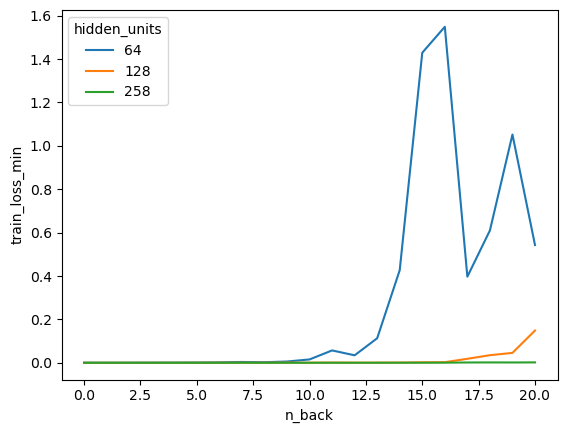

In [101]:
grid_df['acc_max'] = grid_df['acc'].apply(np.max)
grid_df['test_loss_min'] = grid_df['test_loss'].apply(np.min)
grid_df['train_loss_min'] = grid_df['train_loss'].apply(np.min)

import seaborn as sns

sns.lineplot(x='n_back', y='train_loss_min', hue=grid_df['hidden_units'].astype(str), data=grid_df)


In [103]:
np.random.seed(0)

_, acc, test_loss, train_loss = sample_and_train(0, 64, num_layers=1, dropout=0.2, l2_reg=0.00, lr=0.00125, batch_size=128, epochs=50, boundary='periodic')

/home/ikarmann/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1
-------------------------------
Test Error: 
 Accuracy: 53.1%, Avg loss: 1.702690 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 68.9%, Avg loss: 1.094060 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 75.5%, Avg loss: 0.824367 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 81.1%, Avg loss: 0.647759 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 84.8%, Avg loss: 0.534703 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 86.8%, Avg loss: 0.455850 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 89.1%, Avg loss: 0.383990 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 90.0%, Avg loss: 0.346177 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 91.6%, Avg loss: 0.293056 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 92.7%, Avg loss: 0.256658 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 93.8%, Avg los

In [129]:
# Now with periodic boundaries

list_hidden_units = [64, 128, 258]#, 512]
list_n_back = np.arange(21)

grid_dict = { 
    'acc' : [],
    'test_loss' : [],
    'train_loss': [],
    'hidden_units' : [],
    'n_back' : [],
}

for hidden_units, n_back in tqdm(itt.product(list_hidden_units, list_n_back)):

    print(f"Computing with {hidden_units} hidden units, {n_back}-back task")
    _, acc, test_loss, train_loss = sample_and_train(n_back, hidden_units, num_layers=1, lr=0.00125, batch_size=128, epochs=50, boundary='periodic')

    grid_dict['acc'].append(np.array(acc))
    grid_dict['test_loss'].append(np.array(test_loss))
    grid_dict['train_loss'].append(np.array(train_loss))
    grid_dict['hidden_units'].append(hidden_units)
    grid_dict['n_back'].append(n_back)


periodic_df = pd.DataFrame(grid_dict)

periodic_df.to_csv('n_back_periodic_acc.csv')
periodic_df.to_pickle('n_back_periodic_acc.pkl')

0it [00:00, ?it/s]

Computing with 64 hidden units, 0-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 56.2%, Avg loss: 1.595686 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 72.2%, Avg loss: 1.013207 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 79.3%, Avg loss: 0.727153 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 84.2%, Avg loss: 0.541888 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 88.1%, Avg loss: 0.408917 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 90.1%, Avg loss: 0.336251 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 91.4%, Avg loss: 0.298236 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 93.4%, Avg loss: 0.234921 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 94.5%, Avg loss: 0.196845 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 94.8%, Avg loss: 0.178646 

Epoch 11
--------------------------

1it [01:29, 89.81s/it]

Test Error: 
 Accuracy: 94.9%, Avg loss: 0.162167 

Done!
Computing with 64 hidden units, 1-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 28.8%, Avg loss: 2.019525 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 36.3%, Avg loss: 1.629722 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 46.9%, Avg loss: 1.374119 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 58.7%, Avg loss: 1.115689 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 68.3%, Avg loss: 0.902307 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 76.5%, Avg loss: 0.711080 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 81.0%, Avg loss: 0.590150 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 84.9%, Avg loss: 0.493896 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 87.6%, Avg loss: 0.417203 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 88.9%

2it [02:59, 89.64s/it]

Test Error: 
 Accuracy: 99.4%, Avg loss: 0.023077 

Done!
Computing with 64 hidden units, 2-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 46.7%, Avg loss: 1.837067 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 71.5%, Avg loss: 1.005404 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 80.3%, Avg loss: 0.699288 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 86.4%, Avg loss: 0.488203 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 90.0%, Avg loss: 0.363964 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 91.4%, Avg loss: 0.292230 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 93.2%, Avg loss: 0.224972 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 95.5%, Avg loss: 0.157313 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 96.4%, Avg loss: 0.127551 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 97.2%

3it [04:28, 89.53s/it]

Test Error: 
 Accuracy: 99.9%, Avg loss: 0.005615 

Done!
Computing with 64 hidden units, 3-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 23.2%, Avg loss: 2.341793 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 32.9%, Avg loss: 1.462372 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 24.6%, Avg loss: 1.805927 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 33.2%, Avg loss: 1.428592 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 40.7%, Avg loss: 1.282976 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 48.4%, Avg loss: 1.144934 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 61.6%, Avg loss: 0.916066 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 69.1%, Avg loss: 0.745794 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 78.8%, Avg loss: 0.559859 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 79.6%

4it [05:59, 89.91s/it]

Test Error: 
 Accuracy: 99.8%, Avg loss: 0.006486 

Done!
Computing with 64 hidden units, 4-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 14.7%, Avg loss: 2.848381 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 29.3%, Avg loss: 1.744608 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 34.5%, Avg loss: 1.462873 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 16.1%, Avg loss: 2.781006 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 31.9%, Avg loss: 1.470971 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 33.8%, Avg loss: 1.416243 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 42.3%, Avg loss: 1.275239 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 49.1%, Avg loss: 1.154922 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 55.9%, Avg loss: 1.019964 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 63.0%

5it [07:28, 89.61s/it]

Test Error: 
 Accuracy: 99.7%, Avg loss: 0.009093 

Done!
Computing with 64 hidden units, 5-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 13.6%, Avg loss: 2.910503 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 23.6%, Avg loss: 2.111093 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 29.5%, Avg loss: 1.612682 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 31.4%, Avg loss: 1.476161 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 10.3%, Avg loss: 3.000566 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 14.8%, Avg loss: 2.855965 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 19.2%, Avg loss: 2.549772 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 28.1%, Avg loss: 1.710754 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 30.1%, Avg loss: 1.540171 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 30.9%

6it [08:57, 89.51s/it]

Test Error: 
 Accuracy: 94.1%, Avg loss: 0.194519 

Done!
Computing with 64 hidden units, 6-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 12.7%, Avg loss: 2.868047 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 14.2%, Avg loss: 2.792407 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 16.7%, Avg loss: 2.648692 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 21.5%, Avg loss: 2.266816 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 23.8%, Avg loss: 2.101694 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 25.5%, Avg loss: 1.971534 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 26.5%, Avg loss: 1.896050 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 27.1%, Avg loss: 1.852391 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 28.2%, Avg loss: 1.785614 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 28.8%

7it [10:26, 89.15s/it]

Test Error: 
 Accuracy: 32.1%, Avg loss: 1.484194 

Done!
Computing with 64 hidden units, 7-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 13.4%, Avg loss: 2.879979 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 15.6%, Avg loss: 2.799326 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 18.4%, Avg loss: 2.646006 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 24.6%, Avg loss: 2.006547 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 26.1%, Avg loss: 1.873346 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 28.7%, Avg loss: 1.686802 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 30.1%, Avg loss: 1.589670 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 10.9%, Avg loss: 2.976647 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 30.7%, Avg loss: 1.577434 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 31.9%

8it [11:54, 88.92s/it]

Test Error: 
 Accuracy: 26.3%, Avg loss: 1.546702 

Done!
Computing with 64 hidden units, 8-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 14.7%, Avg loss: 2.891624 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 18.7%, Avg loss: 2.708475 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 27.3%, Avg loss: 2.272803 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 35.2%, Avg loss: 1.771062 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 41.2%, Avg loss: 1.504886 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 46.9%, Avg loss: 1.327501 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 52.8%, Avg loss: 1.180971 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 59.5%, Avg loss: 1.015428 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 64.9%, Avg loss: 0.867713 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 68.7%

9it [13:22, 88.72s/it]

Test Error: 
 Accuracy: 99.8%, Avg loss: 0.012547 

Done!
Computing with 64 hidden units, 9-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 12.4%, Avg loss: 2.929273 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 16.2%, Avg loss: 2.756782 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 21.2%, Avg loss: 2.257326 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 25.4%, Avg loss: 1.895026 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 27.2%, Avg loss: 1.778196 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 29.0%, Avg loss: 1.662699 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 30.3%, Avg loss: 1.593120 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 31.0%, Avg loss: 1.552243 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 8.9%, Avg loss: 4.871622 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 20.9%,

10it [14:52, 88.94s/it]

Test Error: 
 Accuracy: 13.2%, Avg loss: 2.838921 

Done!
Computing with 64 hidden units, 10-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 10.8%, Avg loss: 2.956168 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 12.5%, Avg loss: 2.899879 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 15.8%, Avg loss: 2.796308 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 17.8%, Avg loss: 2.725730 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 19.9%, Avg loss: 2.629831 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 20.0%, Avg loss: 2.603360 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 22.6%, Avg loss: 2.496040 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 26.6%, Avg loss: 2.062919 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 29.5%, Avg loss: 1.824809 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 30.9

11it [16:21, 89.02s/it]

Test Error: 
 Accuracy: 74.6%, Avg loss: 0.631041 

Done!
Computing with 64 hidden units, 11-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 10.1%, Avg loss: 2.955010 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 10.4%, Avg loss: 2.947511 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 11.2%, Avg loss: 2.899625 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 13.6%, Avg loss: 2.843340 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 17.1%, Avg loss: 2.758777 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 18.9%, Avg loss: 2.630195 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 20.7%, Avg loss: 2.372205 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 23.8%, Avg loss: 2.058573 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 25.5%, Avg loss: 1.909254 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 26.7

12it [17:50, 88.91s/it]

Test Error: 
 Accuracy: 27.3%, Avg loss: 1.501354 

Done!
Computing with 64 hidden units, 12-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 10.6%, Avg loss: 2.950649 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 10.7%, Avg loss: 2.934831 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 12.1%, Avg loss: 2.884080 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 13.7%, Avg loss: 2.829434 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 13.8%, Avg loss: 2.799011 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 14.9%, Avg loss: 2.703678 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 15.7%, Avg loss: 2.647575 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 17.6%, Avg loss: 2.479209 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 20.0%, Avg loss: 2.229368 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 20.6

13it [19:19, 89.14s/it]

Test Error: 
 Accuracy: 26.5%, Avg loss: 1.604178 

Done!
Computing with 64 hidden units, 13-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 10.8%, Avg loss: 2.930640 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 13.7%, Avg loss: 2.870593 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 15.2%, Avg loss: 2.779739 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 17.0%, Avg loss: 2.740800 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 20.6%, Avg loss: 2.597439 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 21.1%, Avg loss: 2.470171 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 24.1%, Avg loss: 2.166443 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 26.7%, Avg loss: 1.995354 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 28.3%, Avg loss: 1.876629 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 28.5

14it [20:48, 88.90s/it]

Test Error: 
 Accuracy: 65.4%, Avg loss: 0.828898 

Done!
Computing with 64 hidden units, 14-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 10.7%, Avg loss: 3.103205 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 9.1%, Avg loss: 3.005553 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 14.1%, Avg loss: 2.809356 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 14.7%, Avg loss: 2.751468 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 17.6%, Avg loss: 2.512684 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 19.6%, Avg loss: 2.265384 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 20.4%, Avg loss: 2.172875 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 21.7%, Avg loss: 2.046749 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 22.5%, Avg loss: 1.963522 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 23.7%

15it [22:16, 88.84s/it]

Test Error: 
 Accuracy: 26.6%, Avg loss: 1.608067 

Done!
Computing with 64 hidden units, 15-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 8.8%, Avg loss: 3.070506 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 6.0%, Avg loss: 3.195363 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 9.0%, Avg loss: 3.036789 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 13.1%, Avg loss: 2.884644 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 13.3%, Avg loss: 2.844880 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 13.6%, Avg loss: 2.828147 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 13.6%, Avg loss: 2.822913 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 13.6%, Avg loss: 2.812524 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 13.8%, Avg loss: 2.808385 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 13.8%, 

16it [23:44, 88.49s/it]

Test Error: 
 Accuracy: 31.5%, Avg loss: 1.720570 

Done!
Computing with 64 hidden units, 16-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 9.1%, Avg loss: 3.052360 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 9.0%, Avg loss: 3.180787 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 11.9%, Avg loss: 2.894109 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 12.4%, Avg loss: 2.838345 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 12.6%, Avg loss: 2.830343 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 13.2%, Avg loss: 2.787226 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 14.4%, Avg loss: 2.769069 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 18.4%, Avg loss: 2.724403 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 21.2%, Avg loss: 2.611923 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 22.5%,

17it [25:13, 88.67s/it]

Test Error: 
 Accuracy: 89.8%, Avg loss: 0.267870 

Done!
Computing with 64 hidden units, 17-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 9.4%, Avg loss: 3.007124 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 8.5%, Avg loss: 3.199208 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 3.8%, Avg loss: 3.207645 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 12.4%, Avg loss: 2.878404 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 12.5%, Avg loss: 2.868383 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 13.8%, Avg loss: 2.845122 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 13.9%, Avg loss: 2.829779 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 18.1%, Avg loss: 2.749185 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 19.0%, Avg loss: 2.703692 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 19.4%, 

18it [26:41, 88.39s/it]

Test Error: 
 Accuracy: 61.4%, Avg loss: 1.009015 

Done!
Computing with 64 hidden units, 18-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 10.7%, Avg loss: 2.954037 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 12.4%, Avg loss: 2.858980 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 12.5%, Avg loss: 3.064378 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 12.3%, Avg loss: 2.891525 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 12.4%, Avg loss: 2.866401 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 12.4%, Avg loss: 2.836143 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 12.8%, Avg loss: 2.811137 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 13.4%, Avg loss: 2.773832 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 16.1%, Avg loss: 2.714357 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 17.5

19it [28:09, 88.33s/it]

Test Error: 
 Accuracy: 30.0%, Avg loss: 1.467993 

Done!
Computing with 64 hidden units, 19-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 8.7%, Avg loss: 2.992158 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 9.9%, Avg loss: 3.028129 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 8.7%, Avg loss: 2.987584 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 12.5%, Avg loss: 2.917518 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 12.9%, Avg loss: 2.862192 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 13.5%, Avg loss: 2.840305 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 12.7%, Avg loss: 2.829873 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 13.7%, Avg loss: 2.767248 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 14.7%, Avg loss: 2.743126 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 17.0%, 

20it [29:38, 88.43s/it]

Test Error: 
 Accuracy: 65.4%, Avg loss: 0.889664 

Done!
Computing with 64 hidden units, 20-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 10.0%, Avg loss: 3.111149 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 10.2%, Avg loss: 2.950418 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 10.3%, Avg loss: 2.980774 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 16.3%, Avg loss: 2.738451 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 18.2%, Avg loss: 2.623522 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 20.2%, Avg loss: 2.544393 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 21.6%, Avg loss: 2.483559 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 22.5%, Avg loss: 2.416838 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 22.8%, Avg loss: 2.401067 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 23.2

21it [31:05, 88.12s/it]

Test Error: 
 Accuracy: 31.6%, Avg loss: 1.806642 

Done!
Computing with 128 hidden units, 0-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 66.9%, Avg loss: 1.144009 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 80.1%, Avg loss: 0.681851 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 90.7%, Avg loss: 0.313707 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 93.5%, Avg loss: 0.231062 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 94.4%, Avg loss: 0.198287 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.159683 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 96.2%, Avg loss: 0.134247 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 96.9%, Avg loss: 0.105995 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 97.4%, Avg loss: 0.090680 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 97.9

22it [32:58, 95.67s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001885 

Done!
Computing with 128 hidden units, 1-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 69.9%, Avg loss: 1.110305 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 82.2%, Avg loss: 0.577137 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 90.3%, Avg loss: 0.334961 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 93.0%, Avg loss: 0.236698 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 94.9%, Avg loss: 0.173211 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 96.2%, Avg loss: 0.132238 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 96.8%, Avg loss: 0.113558 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.087327 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.074470 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 98.

23it [34:51, 100.91s/it]

Test Error: 
 Accuracy: 99.9%, Avg loss: 0.003775 

Done!
Computing with 128 hidden units, 2-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 58.8%, Avg loss: 1.284518 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 77.0%, Avg loss: 0.695245 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 89.4%, Avg loss: 0.368417 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 93.2%, Avg loss: 0.238917 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 28.3%, Avg loss: 1.579954 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 18.1%, Avg loss: 2.747504 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 34.4%, Avg loss: 1.394745 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 54.8%, Avg loss: 1.069403 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 73.5%, Avg loss: 0.658935 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 85.4

24it [36:44, 104.54s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000113 

Done!
Computing with 128 hidden units, 3-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 30.7%, Avg loss: 1.847501 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 57.8%, Avg loss: 1.117981 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 78.2%, Avg loss: 0.626753 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 88.0%, Avg loss: 0.385255 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 15.9%, Avg loss: 2.854403 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 75.2%, Avg loss: 0.711493 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 93.1%, Avg loss: 0.252855 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 88.9%, Avg loss: 0.357046 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 96.1%, Avg loss: 0.140283 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 96.

25it [38:37, 107.04s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.002572 

Done!
Computing with 128 hidden units, 4-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 18.4%, Avg loss: 2.624271 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 32.3%, Avg loss: 1.453856 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 18.1%, Avg loss: 2.723496 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 18.9%, Avg loss: 2.667905 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 62.1%, Avg loss: 0.965792 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 85.3%, Avg loss: 0.404787 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.154768 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 99.1%, Avg loss: 0.056701 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.019541 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 14.

26it [40:29, 108.42s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000146 

Done!
Computing with 128 hidden units, 5-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 17.0%, Avg loss: 2.754888 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 31.1%, Avg loss: 1.543041 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 35.0%, Avg loss: 1.382479 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 17.5%, Avg loss: 2.739941 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 29.1%, Avg loss: 1.723058 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 35.5%, Avg loss: 1.457487 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 43.4%, Avg loss: 1.298346 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 49.5%, Avg loss: 1.163137 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 59.0%, Avg loss: 0.971862 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 34.

27it [42:20, 109.36s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.003676 

Done!
Computing with 128 hidden units, 6-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 17.2%, Avg loss: 2.738191 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 31.4%, Avg loss: 1.828761 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 48.8%, Avg loss: 1.299273 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 63.1%, Avg loss: 0.936378 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 79.4%, Avg loss: 0.533333 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 87.9%, Avg loss: 0.339886 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 93.4%, Avg loss: 0.212740 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 96.7%, Avg loss: 0.126654 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.078230 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 9.1

28it [44:12, 110.00s/it]

Test Error: 
 Accuracy: 99.9%, Avg loss: 0.009486 

Done!
Computing with 128 hidden units, 7-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 16.3%, Avg loss: 2.772658 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 28.1%, Avg loss: 1.823236 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 32.6%, Avg loss: 1.508092 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 36.0%, Avg loss: 1.375744 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 19.0%, Avg loss: 2.667188 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 29.8%, Avg loss: 1.804723 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 26.0%, Avg loss: 2.000160 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 37.6%, Avg loss: 1.385142 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 15.7%, Avg loss: 2.813152 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 34.9

29it [46:04, 110.56s/it]

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.022983 

Done!
Computing with 128 hidden units, 8-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 11.2%, Avg loss: 2.960144 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 23.9%, Avg loss: 2.353522 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 33.6%, Avg loss: 1.797563 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 44.6%, Avg loss: 1.459773 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 71.1%, Avg loss: 0.822645 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 85.2%, Avg loss: 0.447134 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 92.1%, Avg loss: 0.252919 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 95.2%, Avg loss: 0.157119 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.143282 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 97.2

30it [47:55, 110.77s/it]

Test Error: 
 Accuracy: 99.9%, Avg loss: 0.003598 

Done!
Computing with 128 hidden units, 9-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 13.5%, Avg loss: 2.778512 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 23.1%, Avg loss: 1.857417 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 25.1%, Avg loss: 1.652719 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 26.0%, Avg loss: 1.561627 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 26.4%, Avg loss: 1.535379 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 26.7%, Avg loss: 1.510248 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 11.8%, Avg loss: 3.250715 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 26.0%, Avg loss: 1.605832 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 26.2%, Avg loss: 1.575484 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 26.7

31it [49:47, 111.07s/it]

Test Error: 
 Accuracy: 76.8%, Avg loss: 0.661068 

Done!
Computing with 128 hidden units, 10-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 10.9%, Avg loss: 2.944432 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 14.5%, Avg loss: 2.775356 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 20.2%, Avg loss: 2.474996 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 25.7%, Avg loss: 2.057535 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 28.5%, Avg loss: 1.876132 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 30.5%, Avg loss: 1.727920 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 30.5%, Avg loss: 1.735086 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 32.6%, Avg loss: 1.582824 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 33.8%, Avg loss: 1.494218 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 34.

32it [51:38, 111.11s/it]

Test Error: 
 Accuracy: 13.4%, Avg loss: 2.838460 

Done!
Computing with 128 hidden units, 11-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 10.5%, Avg loss: 2.947492 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 15.2%, Avg loss: 2.805454 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 21.8%, Avg loss: 2.495406 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 29.2%, Avg loss: 1.876136 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 32.5%, Avg loss: 1.622009 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 34.8%, Avg loss: 1.497517 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 36.6%, Avg loss: 1.422060 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 21.3%, Avg loss: 2.536823 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 38.5%, Avg loss: 1.356233 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 34.

33it [53:30, 111.26s/it]

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.026687 

Done!
Computing with 128 hidden units, 12-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 10.2%, Avg loss: 2.950036 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 16.0%, Avg loss: 2.686655 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 22.1%, Avg loss: 2.049786 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 25.4%, Avg loss: 1.736804 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 26.6%, Avg loss: 1.606220 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 27.6%, Avg loss: 1.522553 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 24.2%, Avg loss: 1.828079 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 26.3%, Avg loss: 1.622620 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 15.4%, Avg loss: 2.665343 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 27.

34it [55:21, 111.31s/it]

Test Error: 
 Accuracy: 96.1%, Avg loss: 0.123503 

Done!
Computing with 128 hidden units, 13-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 12.2%, Avg loss: 2.910159 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 18.4%, Avg loss: 2.619650 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 25.0%, Avg loss: 2.246725 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 31.2%, Avg loss: 1.943172 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 35.4%, Avg loss: 1.773818 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 37.7%, Avg loss: 1.678077 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 41.6%, Avg loss: 1.519224 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 47.9%, Avg loss: 1.438429 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 63.9%, Avg loss: 0.952203 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 80.

35it [57:12, 111.31s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.002348 

Done!
Computing with 128 hidden units, 14-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 10.3%, Avg loss: 2.969673 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 11.8%, Avg loss: 2.898114 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 15.3%, Avg loss: 2.776120 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 18.6%, Avg loss: 2.592538 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 20.0%, Avg loss: 2.521275 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 23.6%, Avg loss: 2.274056 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 26.1%, Avg loss: 2.060504 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 27.4%, Avg loss: 1.959014 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 28.4%, Avg loss: 1.914111 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 29

36it [59:04, 111.33s/it]

Test Error: 
 Accuracy: 59.8%, Avg loss: 0.951770 

Done!
Computing with 128 hidden units, 15-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 8.1%, Avg loss: 3.021718 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 10.1%, Avg loss: 2.974571 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 11.5%, Avg loss: 2.910175 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 13.1%, Avg loss: 2.863927 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 16.8%, Avg loss: 2.677471 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 24.2%, Avg loss: 2.087498 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 29.1%, Avg loss: 1.777680 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 31.4%, Avg loss: 1.650896 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 33.4%, Avg loss: 1.551942 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 35.0

37it [1:00:55, 111.37s/it]

Test Error: 
 Accuracy: 99.7%, Avg loss: 0.018201 

Done!
Computing with 128 hidden units, 16-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 11.5%, Avg loss: 2.897838 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 11.3%, Avg loss: 2.925513 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 11.6%, Avg loss: 2.891535 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 16.2%, Avg loss: 2.694696 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 20.9%, Avg loss: 2.207878 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 23.4%, Avg loss: 1.960706 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 24.5%, Avg loss: 1.838885 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 25.3%, Avg loss: 1.759963 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 25.9%, Avg loss: 1.719934 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 25.

38it [1:02:46, 111.32s/it]

Test Error: 
 Accuracy: 97.7%, Avg loss: 0.075906 

Done!
Computing with 128 hidden units, 17-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 11.9%, Avg loss: 2.895096 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 13.1%, Avg loss: 2.854952 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 17.9%, Avg loss: 2.685554 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 23.3%, Avg loss: 2.215999 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 29.4%, Avg loss: 1.811850 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 32.4%, Avg loss: 1.636684 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 35.1%, Avg loss: 1.564577 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 37.1%, Avg loss: 1.455910 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 39.3%, Avg loss: 1.443110 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 48.

39it [1:04:38, 111.24s/it]

Test Error: 
 Accuracy: 68.2%, Avg loss: 1.967593 

Done!
Computing with 128 hidden units, 18-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 14.6%, Avg loss: 2.848821 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 17.9%, Avg loss: 2.653795 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 22.3%, Avg loss: 2.426075 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 25.8%, Avg loss: 2.224950 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 29.4%, Avg loss: 2.036587 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 33.0%, Avg loss: 1.907756 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 38.0%, Avg loss: 1.770957 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 41.4%, Avg loss: 1.611299 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 44.2%, Avg loss: 1.510928 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 47.

40it [1:06:29, 111.21s/it]

Test Error: 
 Accuracy: 98.7%, Avg loss: 0.057346 

Done!
Computing with 128 hidden units, 19-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 7.8%, Avg loss: 3.217340 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 12.7%, Avg loss: 2.846176 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 12.8%, Avg loss: 2.836396 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 13.2%, Avg loss: 2.838513 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 8.9%, Avg loss: 2.993264 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 13.6%, Avg loss: 2.842778 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 19.1%, Avg loss: 2.681301 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 24.1%, Avg loss: 2.460951 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 29.5%, Avg loss: 2.262228 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 33.8%

41it [1:08:20, 111.21s/it]

Test Error: 
 Accuracy: 86.4%, Avg loss: 0.353839 

Done!
Computing with 128 hidden units, 20-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 3.9%, Avg loss: 3.568604 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 13.2%, Avg loss: 2.828888 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 13.2%, Avg loss: 2.828983 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 13.4%, Avg loss: 2.820457 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 15.3%, Avg loss: 2.762521 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 20.3%, Avg loss: 2.422187 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 23.2%, Avg loss: 2.116557 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 26.3%, Avg loss: 1.824327 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 28.1%, Avg loss: 1.672772 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 29.0

42it [1:10:10, 111.03s/it]

Test Error: 
 Accuracy: 94.7%, Avg loss: 0.148297 

Done!
Computing with 258 hidden units, 0-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 82.5%, Avg loss: 0.647144 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 93.4%, Avg loss: 0.225605 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 96.3%, Avg loss: 0.127457 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.088071 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.059671 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 98.7%, Avg loss: 0.046502 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 99.1%, Avg loss: 0.032316 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.025617 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 99.4%, Avg loss: 0.023678 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 99.7

43it [1:14:10, 149.56s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000625 

Done!
Computing with 258 hidden units, 1-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 83.5%, Avg loss: 0.607328 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 93.5%, Avg loss: 0.238318 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 96.6%, Avg loss: 0.129915 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.082415 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.088576 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 99.0%, Avg loss: 0.040592 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.028173 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 99.5%, Avg loss: 0.028626 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.016810 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 99.

44it [1:18:11, 177.05s/it]

Test Error: 
 Accuracy: 97.9%, Avg loss: 0.059880 

Done!
Computing with 258 hidden units, 2-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 78.3%, Avg loss: 0.679200 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 93.8%, Avg loss: 0.222203 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 80.0%, Avg loss: 0.643976 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 96.4%, Avg loss: 0.147544 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.082381 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.056466 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 99.0%, Avg loss: 0.044548 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 98.8%, Avg loss: 0.052356 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 99.4%, Avg loss: 0.026135 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 99.5

45it [1:22:12, 196.32s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.004107 

Done!
Computing with 258 hidden units, 3-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 74.7%, Avg loss: 0.806570 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 94.4%, Avg loss: 0.207310 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 97.1%, Avg loss: 0.111617 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.088497 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 99.0%, Avg loss: 0.042451 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.029792 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 99.1%, Avg loss: 0.042577 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 99.5%, Avg loss: 0.021082 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 99.5%, Avg loss: 0.017819 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 99.

46it [1:26:13, 209.68s/it]

Test Error: 
 Accuracy: 99.8%, Avg loss: 0.006810 

Done!
Computing with 258 hidden units, 4-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 44.3%, Avg loss: 1.469728 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 90.8%, Avg loss: 0.276642 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 97.3%, Avg loss: 0.098238 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 90.4%, Avg loss: 0.331301 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.033413 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 81.2%, Avg loss: 0.616217 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 92.0%, Avg loss: 0.222522 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 33.7%, Avg loss: 1.566397 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 95.5%, Avg loss: 0.139840 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 97.1

47it [1:30:15, 219.23s/it]

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.047189 

Done!
Computing with 258 hidden units, 5-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 20.1%, Avg loss: 2.610413 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 85.0%, Avg loss: 0.419364 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 97.0%, Avg loss: 0.115929 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 99.4%, Avg loss: 0.053564 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.014979 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 16.8%, Avg loss: 2.800093 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 41.2%, Avg loss: 1.240371 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 30.6%, Avg loss: 2.310042 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 99.0%, Avg loss: 0.073295 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 99.9

48it [1:34:15, 225.62s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005169 

Done!
Computing with 258 hidden units, 6-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 23.7%, Avg loss: 2.174012 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 34.4%, Avg loss: 1.390654 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 13.3%, Avg loss: 2.929875 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 50.2%, Avg loss: 1.145965 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 10.5%, Avg loss: 2.953327 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 71.8%, Avg loss: 0.782043 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 92.3%, Avg loss: 0.251715 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 97.6%, Avg loss: 0.088015 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.029028 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 99.

49it [1:38:17, 230.39s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000150 

Done!
Computing with 258 hidden units, 7-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 23.1%, Avg loss: 2.546453 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 70.8%, Avg loss: 0.811246 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 91.4%, Avg loss: 0.268177 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 96.4%, Avg loss: 0.118890 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 97.9%, Avg loss: 0.069467 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.051797 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 99.0%, Avg loss: 0.032975 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 95.4%, Avg loss: 0.136730 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 98.8%, Avg loss: 0.042835 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 95.

50it [1:42:17, 233.34s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000421 

Done!
Computing with 258 hidden units, 8-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 27.1%, Avg loss: 2.316798 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 78.1%, Avg loss: 0.566591 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 93.0%, Avg loss: 0.206903 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 95.1%, Avg loss: 0.133867 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.068388 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.015049 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 31.5%, Avg loss: 2.307597 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.016009 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.009284 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 100

51it [1:46:18, 235.69s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000158 

Done!
Computing with 258 hidden units, 9-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 18.0%, Avg loss: 2.724255 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 70.9%, Avg loss: 0.762963 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 93.4%, Avg loss: 0.222022 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 98.8%, Avg loss: 0.060557 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.044655 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.014523 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 19.1%, Avg loss: 2.711587 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.064875 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 99.4%, Avg loss: 0.034692 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 99.

52it [1:50:19, 237.16s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.002003 

Done!
Computing with 258 hidden units, 10-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 14.6%, Avg loss: 2.843335 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 39.1%, Avg loss: 1.656607 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 85.8%, Avg loss: 0.384878 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 94.0%, Avg loss: 0.187624 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 98.7%, Avg loss: 0.057360 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 21.4%, Avg loss: 2.199999 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.063873 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.020192 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.019507 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 99

53it [1:54:20, 238.23s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.002273 

Done!
Computing with 258 hidden units, 11-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 19.0%, Avg loss: 2.689124 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 41.2%, Avg loss: 1.711291 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 64.6%, Avg loss: 0.934798 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 79.3%, Avg loss: 0.547491 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 84.3%, Avg loss: 0.424078 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 78.3%, Avg loss: 0.616497 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 94.6%, Avg loss: 0.183738 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 89.8%, Avg loss: 0.297279 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 96.2%, Avg loss: 0.141099 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 96

54it [1:58:20, 238.93s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001113 

Done!
Computing with 258 hidden units, 12-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 13.0%, Avg loss: 2.911552 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 17.2%, Avg loss: 2.701920 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 32.7%, Avg loss: 1.917228 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 71.9%, Avg loss: 0.767937 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 89.8%, Avg loss: 0.313032 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 95.8%, Avg loss: 0.148427 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 97.2%, Avg loss: 0.097998 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 94.8%, Avg loss: 0.181779 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 99.0%, Avg loss: 0.041989 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 98

55it [2:02:21, 239.56s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001750 

Done!
Computing with 258 hidden units, 13-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 16.4%, Avg loss: 2.827254 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 24.4%, Avg loss: 2.335198 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 44.2%, Avg loss: 1.413424 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 73.7%, Avg loss: 0.655886 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 79.2%, Avg loss: 0.516541 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 92.3%, Avg loss: 0.216279 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 97.2%, Avg loss: 0.115044 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 99.0%, Avg loss: 0.046471 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 26.0%, Avg loss: 2.406883 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 97

56it [2:06:21, 239.77s/it]

Test Error: 
 Accuracy: 47.3%, Avg loss: 1.611962 

Done!
Computing with 258 hidden units, 14-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 9.7%, Avg loss: 3.018424 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 21.3%, Avg loss: 2.427118 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 27.0%, Avg loss: 2.020506 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 28.6%, Avg loss: 1.770926 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 34.6%, Avg loss: 1.476276 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 35.9%, Avg loss: 1.392117 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 36.8%, Avg loss: 1.352893 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 44.6%, Avg loss: 1.269229 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 90.5%, Avg loss: 0.272131 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 97.4

57it [2:10:22, 240.07s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001168 

Done!
Computing with 258 hidden units, 15-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 10.7%, Avg loss: 2.942264 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 11.4%, Avg loss: 2.903439 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 15.5%, Avg loss: 2.786511 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 25.4%, Avg loss: 1.999429 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 30.9%, Avg loss: 1.620292 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 35.1%, Avg loss: 1.458434 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 38.8%, Avg loss: 1.333702 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 49.0%, Avg loss: 1.167994 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 69.8%, Avg loss: 0.717074 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 82

58it [2:14:22, 239.95s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.002745 

Done!
Computing with 258 hidden units, 16-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 13.5%, Avg loss: 2.887187 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 22.0%, Avg loss: 2.438598 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 27.9%, Avg loss: 2.023678 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 31.3%, Avg loss: 1.805824 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 33.0%, Avg loss: 1.703277 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 35.2%, Avg loss: 1.535902 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 35.7%, Avg loss: 1.504333 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 36.8%, Avg loss: 1.439717 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 37.3%, Avg loss: 1.435044 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 58

59it [2:18:23, 240.27s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.002203 

Done!
Computing with 258 hidden units, 17-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 9.5%, Avg loss: 3.053258 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 22.6%, Avg loss: 2.394850 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 29.5%, Avg loss: 1.931194 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 32.9%, Avg loss: 1.719725 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 34.8%, Avg loss: 1.589088 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 35.8%, Avg loss: 1.553083 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 36.3%, Avg loss: 1.525383 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 38.4%, Avg loss: 1.379934 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 38.8%, Avg loss: 1.354630 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 39.

60it [2:22:23, 240.30s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001008 

Done!
Computing with 258 hidden units, 18-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 10.2%, Avg loss: 2.971284 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 17.2%, Avg loss: 2.711631 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 24.3%, Avg loss: 2.288718 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 30.3%, Avg loss: 1.888857 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 33.3%, Avg loss: 1.688933 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 34.7%, Avg loss: 1.593852 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 36.3%, Avg loss: 1.491759 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 36.8%, Avg loss: 1.452566 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 38.3%, Avg loss: 1.373208 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 38

61it [2:26:23, 240.22s/it]

Test Error: 
 Accuracy: 99.9%, Avg loss: 0.004740 

Done!
Computing with 258 hidden units, 19-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 9.8%, Avg loss: 3.209781 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 17.0%, Avg loss: 2.633555 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 23.8%, Avg loss: 1.985371 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 26.6%, Avg loss: 1.724769 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 28.0%, Avg loss: 1.613509 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 26.7%, Avg loss: 1.739170 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 27.7%, Avg loss: 1.676710 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 29.9%, Avg loss: 1.493263 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 30.3%, Avg loss: 1.463237 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 29.5

62it [2:30:24, 240.23s/it]

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.002315 

Done!
Computing with 258 hidden units, 20-back task
Epoch 1
-------------------------------
Test Error: 
 Accuracy: 10.1%, Avg loss: 3.165189 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 10.0%, Avg loss: 3.071863 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 19.3%, Avg loss: 2.486105 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 25.0%, Avg loss: 1.924496 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 27.2%, Avg loss: 1.724570 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 28.0%, Avg loss: 1.652590 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 28.9%, Avg loss: 1.567201 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 30.2%, Avg loss: 1.488402 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 30.8%, Avg loss: 1.454094 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 31

63it [2:34:24, 147.05s/it]

Test Error: 
 Accuracy: 99.8%, Avg loss: 0.013280 

Done!


/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

<Axes: xlabel='n_back', ylabel='acc_max'>

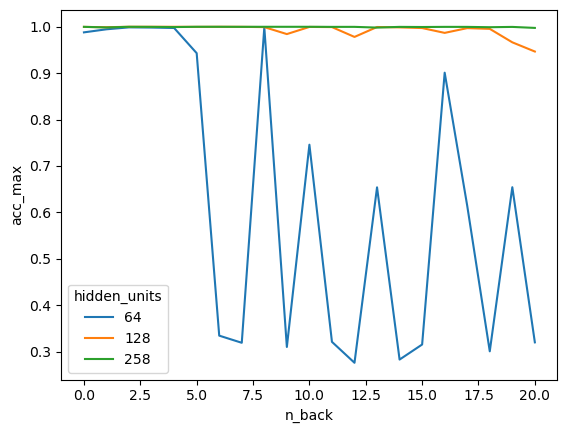

In [130]:
periodic_df['acc_max'] = periodic_df['acc'].apply(np.max)
periodic_df['test_loss_min'] = periodic_df['test_loss'].apply(np.min)
periodic_df['train_loss_min'] = periodic_df['train_loss'].apply(np.min)

sns.lineplot(x='n_back', y='acc_max', hue=periodic_df['hidden_units'].astype(str), data=periodic_df)

In [73]:
model_zero, acc, test_loss, train_loss = sample_and_train(0, 256, num_layers=1, dropout=0.2, l2_reg=0.00, lr=0.00125, batch_size=128, epochs=50, boundary='strict')

/home/ikarmann/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1
-------------------------------
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.088428 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 97.6%, Avg loss: 0.015265 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 97.6%, Avg loss: 0.005754 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 97.6%, Avg loss: 0.003204 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 97.6%, Avg loss: 0.002874 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 97.6%, Avg loss: 0.001438 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 97.6%, Avg loss: 0.002055 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 97.6%, Avg loss: 0.000888 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 97.6%, Avg loss: 0.000528 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 97.6%, Avg loss: 0.000329 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 97.6%, Avg los

In [81]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plot_hidden_tsne(model, dataset, step_pos=-1, step_hidden=-1):

    assert step_hidden != 0, "Step zero has trivial representation."
    
    model.eval()
    
    with torch.no_grad():
        _, hidden_states = model.forward(dataset.x.to(device), return_hidden=True)

    hidden_states = hidden_states.cpu().numpy()[:,step_hidden]
    np.random.seed(0)
    transformed = TSNE(2).fit_transform(hidden_states)
    
    sns.set()
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=analysis_dataset.y.numpy()[:,step_pos].astype('str'))
    plt.legend('', frameon=False)
    plt.title(f't-SNE of Hidden-states at step {step_hidden} colored according to position at step {step_pos}')
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')

def plot_hidden_pca(model, dataset, step_pos=-1, step_hidden=-1):

    assert step_hidden != 0, "Step zero has trivial representation."
    
    
    model.eval()
    
    with torch.no_grad():
        _, hidden_states = model.forward(dataset.x.to(device), return_hidden=True)

    hidden_states = hidden_states.cpu().numpy()[:,step_hidden]
    np.random.seed(0)
    transformed = PCA(2).fit_transform(hidden_states)
    
    sns.set()
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=analysis_dataset.y.numpy()[:,step_pos].astype('str'))
    plt.legend('', frameon=False)

    plt.title(f'PCA of Hidden-states at step {step_hidden} colored according to position at step {step_pos}')
    plt.xlabel('Dim 1')
    plt.ylabel('Dim 2')

In [ ]:
analysis_dataset = create_n_back_dataset(1000, 0, boundary='strict')

torch.Size([1000, 41, 256])


/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

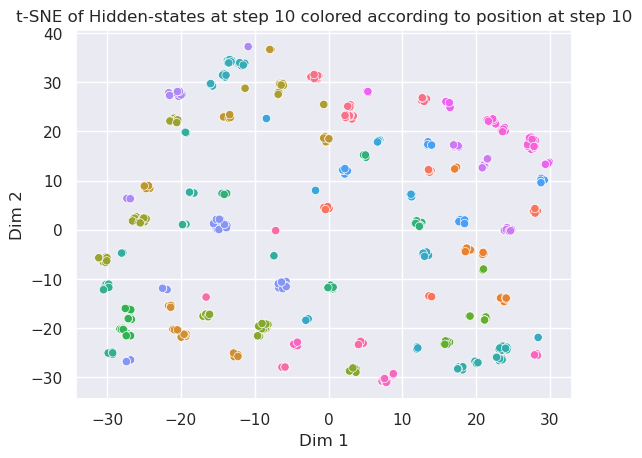

In [82]:
plot_hidden_tsne(model_zero, analysis_dataset, step_pos=10, step_hidden=10)

torch.Size([1000, 41, 256])


/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

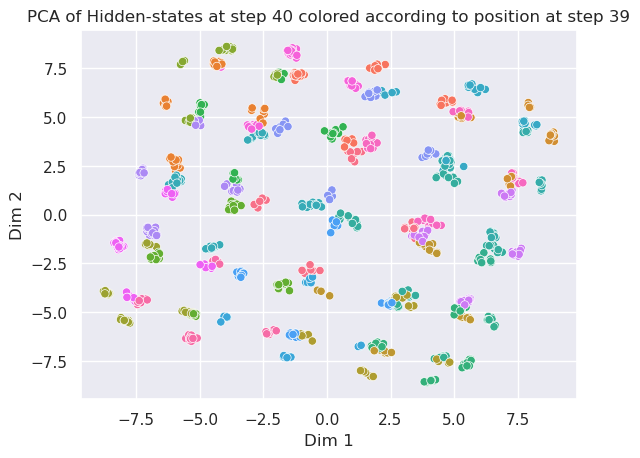

In [88]:
plot_hidden_pca(model_zero, analysis_dataset, step_pos=39, step_hidden=40)

In [29]:
model_one, acc, test_loss, train_loss = sample_and_train(1, 256, num_layers=1, dropout=0.2, l2_reg=0.00, lr=0.00125, batch_size=128, epochs=50, boundary='strict')

/home/ikarmann/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.031853 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.004988 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001713 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000758 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000373 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000196 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000109 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000061 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 82.1%, Avg loss: 0.596929 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.005703 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 100.0

torch.Size([1000, 41, 256])


/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

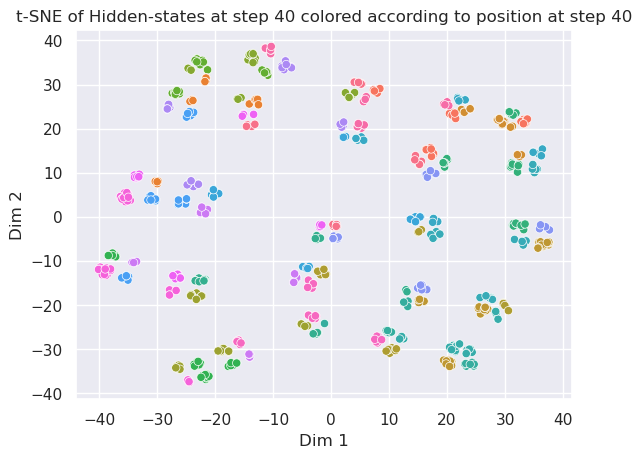

In [85]:
plot_hidden_tsne(model_one, analysis_dataset, step_pos=40, step_hidden=40)

torch.Size([1000, 41, 256])


/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

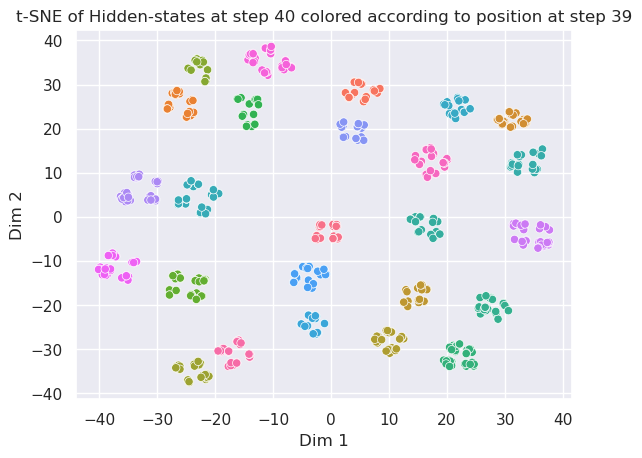

In [86]:
plot_hidden_tsne(model_one, analysis_dataset, step_pos=39, step_hidden=40)

In [87]:
model_two, acc, test_loss, train_loss = sample_and_train(2, 256, num_layers=1, dropout=0.2, l2_reg=0.00, lr=0.00125, batch_size=128, epochs=50, boundary='strict')

/home/ikarmann/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1
-------------------------------
Test Error: 
 Accuracy: 99.4%, Avg loss: 0.055959 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008637 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.002022 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000816 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000388 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000201 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000109 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000061 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000034 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000020 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 100.0

torch.Size([1000, 41, 256])


/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

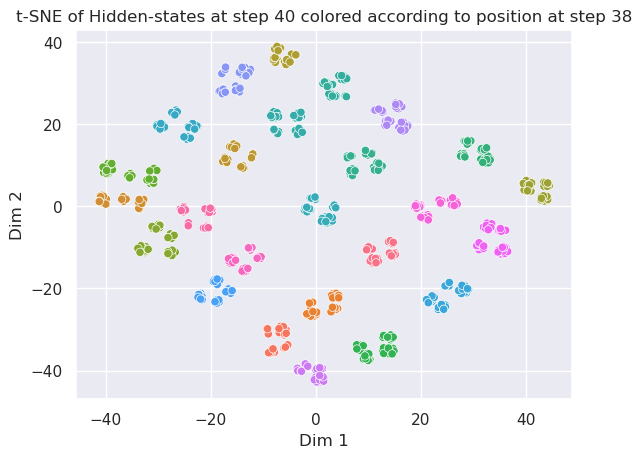

In [92]:
plot_hidden_tsne(model_two, analysis_dataset, step_pos=38, step_hidden=40)

torch.Size([1000, 41, 256])


/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

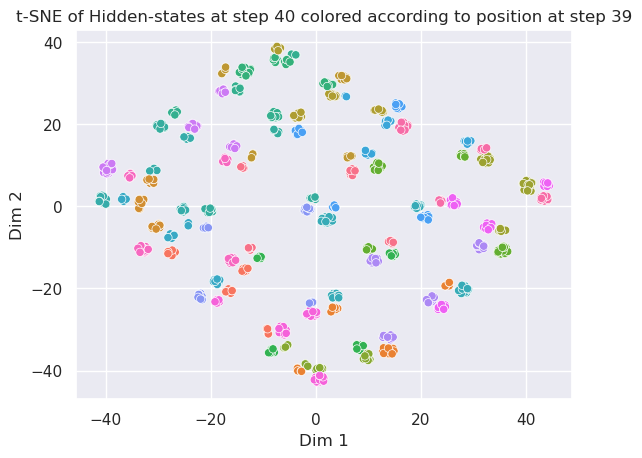

In [93]:
plot_hidden_tsne(model_two, analysis_dataset, step_pos=39, step_hidden=40)

In [94]:
model_ten, acc, test_loss, train_loss = sample_and_train(10, 256, num_layers=1, dropout=0.2, l2_reg=0.00, lr=0.00125, batch_size=128, epochs=50, boundary='strict')

/home/ikarmann/anaconda3/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 1
-------------------------------
Test Error: 
 Accuracy: 55.4%, Avg loss: 1.138334 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 81.2%, Avg loss: 0.515318 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 97.6%, Avg loss: 0.096559 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.045622 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.003282 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.003583 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000842 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000389 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000223 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.003167 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 100.0%, 

torch.Size([1000, 41, 256])


/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

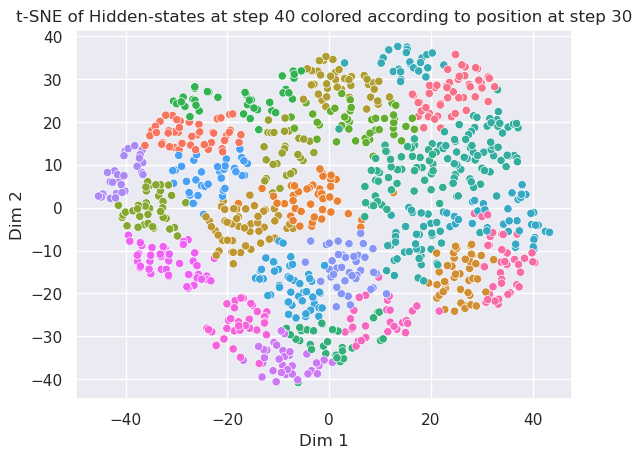

In [95]:
plot_hidden_tsne(model_ten, analysis_dataset, step_pos=30, step_hidden=40)

torch.Size([1000, 41, 256])


/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ikarmann/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

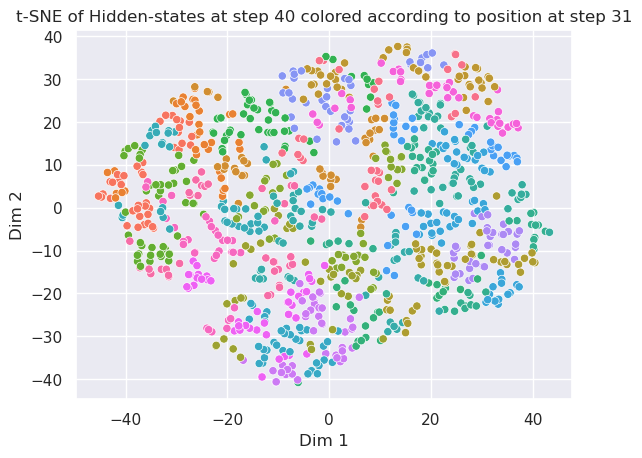

In [96]:
plot_hidden_tsne(model_ten, analysis_dataset, step_pos=31, step_hidden=40)

In [202]:
from scipy.cluster.hierarchy import fclusterdata
from sklearn.decomposition import FastICA, SparsePCA
from sklearn.manifold import LocallyLinearEmbedding

def scree_plot(model, dataset, plot_components=50):
    model.eval()
    
    with torch.no_grad():
        logits, hidden_states = model.forward(dataset.x.to(device), return_hidden=True)

    hidden_states = hidden_states.cpu().numpy()[:,-1]
    pca = PCA(hidden_states.shape[-1])
    transformed = pca.fit_transform(hidden_states)

    PC_values = np.arange(pca.n_components_) + 1
    plt.plot(PC_values[:plot_components], pca.explained_variance_ratio_[:plot_components], 'o-', linewidth=2, color='blue')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained')
    plt.show()
    
def past_coding_plot(model, dataset, n_back_max, plot_components=50):
    
    model.eval()
    
    with torch.no_grad():
        logits, hidden_states = model.forward(dataset.x.to(device), return_hidden=True)

    hidden_states = hidden_states.cpu().numpy()[:,-1]
    transformed = FastICA(plot_components).fit_transform(hidden_states)

    num_classes = logits.size()[1]
    num_components = transformed.shape[1]
    
    y = F.one_hot(analysis_dataset.y, num_classes=num_classes).numpy()

    r2_matrix = np.zeros([n_back_max, num_components])
    
    for n in range(n_back_max):
        pos = y[:, -(n+1)]
        betas = np.linalg.inv(pos.T @ pos) @ pos.T @ transformed
        resids = pos @ betas - transformed
        r2 = 1 - np.var(resids, axis=0)/np.var(transformed, axis=0)
        r2_matrix[n] = r2

    r2_matrix_ = r2_matrix[:,:plot_components]
    idx = np.lexsort(r2_matrix_[::-1])
    r2_matrix_ = r2_matrix_[:, idx]
    
    fig, ax = plt.subplots(figsize=(9,8))
    im = ax.imshow(r2_matrix_, aspect='auto', interpolation='nearest')
    cbar = plt.colorbar(im)
    sns.reset_orig()
    plt.title('Explained variance of last state IC by previous positions')
    plt.xlabel('Independent Component')
    plt.ylabel('Delay')
    plt.show()

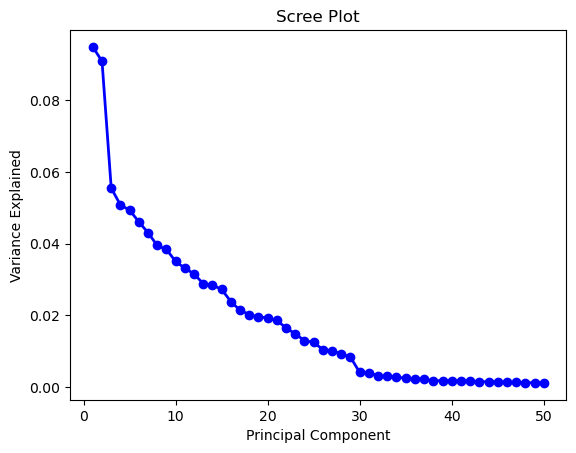

In [203]:
scree_plot(model_ten, analysis_dataset)

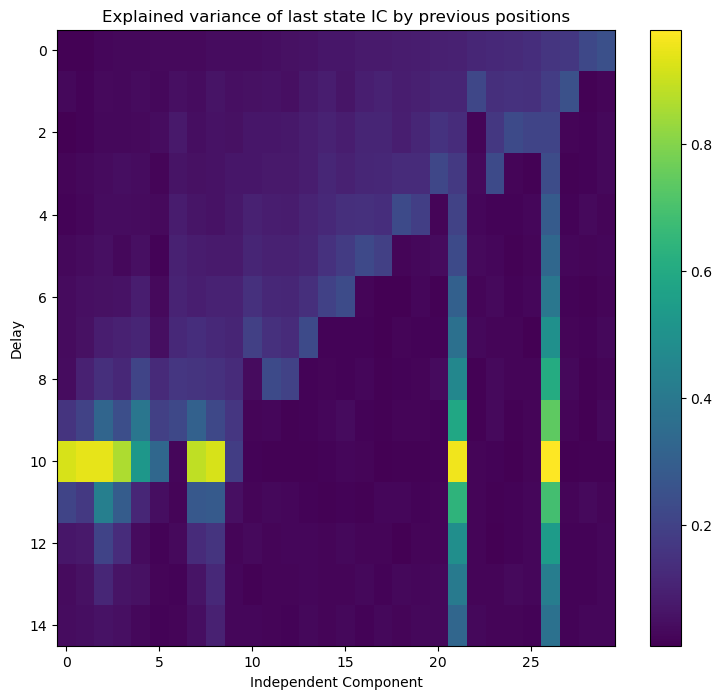

In [204]:
past_coding_plot(model_ten, analysis_dataset, 15, plot_components=30)